In [1]:
!pip install pandas numpy matplotlib seaborn scikit-learn torch torchvision torchaudio shap ucimlrepo

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 83.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 87.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 67.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 45.1 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlink

In [18]:

# ---------------------------------------------------------------------------
# 1. Environment & Repository Setup (Libraries)
# ---------------------------------------------------------------------------
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-learn imports
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, ConfusionMatrixDisplay,
    matthews_corrcoef, average_precision_score
)

# PyTorch imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# SHAP import
import shap

# UCIMLRepo import
from ucimlrepo import fetch_ucirepo

# Note: Setting random seeds is crucial for reproducibility
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
os.environ['PYTHONHASHSEED'] = str(SEED)

print("Libraries imported and seed set.")

Libraries imported and seed set.


In [19]:
# ---------------------------------------------------------------------------
# 2. Data Loading & Rigorous Preprocessing
# ---------------------------------------------------------------------------

# --- 2.1. Fetch Dataset ---
print("\nFetching dataset...")
breast_cancer_wisconsin_diagnostic = fetch_ucirepo(id=17)
X_raw = breast_cancer_wisconsin_diagnostic.data.features
y_raw = breast_cancer_wisconsin_diagnostic.data.targets

print(f"Features shape: {X_raw.shape}")
print(f"Target shape: {y_raw.shape}")
print("\nFirst 5 rows of features:")
print(X_raw.head())
print("\nTarget value counts:")
print(y_raw['Diagnosis'].value_counts())
print("\nDataset fetched and initial inspection complete.")


Fetching dataset...
Features shape: (569, 30)
Target shape: (569, 1)

First 5 rows of features:
   radius1  texture1  perimeter1   area1  smoothness1  compactness1  \
0    17.99     10.38      122.80  1001.0      0.11840       0.27760   
1    20.57     17.77      132.90  1326.0      0.08474       0.07864   
2    19.69     21.25      130.00  1203.0      0.10960       0.15990   
3    11.42     20.38       77.58   386.1      0.14250       0.28390   
4    20.29     14.34      135.10  1297.0      0.10030       0.13280   

   concavity1  concave_points1  symmetry1  fractal_dimension1  ...  radius3  \
0      0.3001          0.14710     0.2419             0.07871  ...    25.38   
1      0.0869          0.07017     0.1812             0.05667  ...    24.99   
2      0.1974          0.12790     0.2069             0.05999  ...    23.57   
3      0.2414          0.10520     0.2597             0.09744  ...    14.91   
4      0.1980          0.10430     0.1809             0.05883  ...    22.54   

 

In [20]:
# --- 2.2. Encode Target Variable ---
# 'M' (Malignant) will be 1, 'B' (Benign) will be 0.
print("\nEncoding target variable...")
label_encoder = LabelEncoder()
y_encoded_temp = label_encoder.fit_transform(y_raw['Diagnosis']) # Mapped to 0 and 1

# Ensure M (Malignant) is 1 (positive class) and B (Benign) is 0 (negative class)
# This is a common convention and helps with interpreting metrics like precision/recall.
if label_encoder.transform(['M'])[0] == 0: # If Malignant was mapped to 0 by LabelEncoder
    print("Original LabelEncoder mapping: M -> 0, B -> 1. Flipping to M -> 1, B -> 0.")
    y = 1 - y_encoded_temp # Flip: 0 becomes 1, 1 becomes 0
else: # If Malignant was already mapped to 1
    print("Original LabelEncoder mapping: M -> 1, B -> 0. No flipping needed.")
    y = y_encoded_temp

print(f"Encoded target unique values and counts (0=Benign, 1=Malignant): {np.unique(y, return_counts=True)}")
print("Target variable encoded.")


Encoding target variable...
Original LabelEncoder mapping: M -> 1, B -> 0. No flipping needed.
Encoded target unique values and counts (0=Benign, 1=Malignant): (array([0, 1]), array([357, 212]))
Target variable encoded.


In [21]:
# --- 2.3. Data Splitting (Stratified) ---
print("\nSplitting data into train, validation, and test sets...")
# 70% train, 30% temp
sss_train_temp = StratifiedShuffleSplit(n_splits=1, test_size=0.30, random_state=SEED)
for train_index, temp_index in sss_train_temp.split(X_raw, y): # Use y (numeric) for stratification
    X_train, X_temp = X_raw.iloc[train_index], X_raw.iloc[temp_index]
    y_train, y_temp = y[train_index], y[temp_index]

# Split temp into validation and test (0.15 original / 0.30 temp = 0.5 of temp set for test)
sss_val_test = StratifiedShuffleSplit(n_splits=1, test_size=0.50, random_state=SEED)
for val_index, test_index in sss_val_test.split(X_temp, y_temp):
    X_val, X_test = X_temp.iloc[val_index], X_temp.iloc[test_index]
    y_val, y_test = y_temp[val_index], y_temp[test_index]

print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

print(f"\nTrain target distribution (0=B, 1=M): {np.bincount(y_train)/len(y_train)}")
print(f"Validation target distribution (0=B, 1=M): {np.bincount(y_val)/len(y_val)}")
print(f"Test target distribution (0=B, 1=M): {np.bincount(y_test)/len(y_test)}")
print("Data splitting complete.")


Splitting data into train, validation, and test sets...
X_train shape: (398, 30), y_train shape: (398,)
X_val shape: (85, 30), y_val shape: (85,)
X_test shape: (86, 30), y_test shape: (86,)

Train target distribution (0=B, 1=M): [0.6281407 0.3718593]
Validation target distribution (0=B, 1=M): [0.62352941 0.37647059]
Test target distribution (0=B, 1=M): [0.62790698 0.37209302]
Data splitting complete.


In [22]:
# --- 2.4. Feature Scaling ---
print("\nScaling features...")
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

print("Feature scaling complete.")
print("X_train_scaled sample (first 5 rows):")
print(pd.DataFrame(X_train_scaled, columns=X_train.columns).head())


Scaling features...
Feature scaling complete.
X_train_scaled sample (first 5 rows):
    radius1  texture1  perimeter1     area1  smoothness1  compactness1  \
0  1.705820  1.049745    2.121295  1.669337     2.276458      4.544295   
1  0.536388 -0.909945    0.569095  0.390316    -0.065868      0.644945   
2 -0.131456 -0.993336   -0.148848 -0.211543    -0.916169     -0.508574   
3  0.928077  1.418055    0.925405  0.828546     0.329734      0.223748   
4  0.144699 -0.972488    0.158315 -0.009697     1.205760      0.585041   

   concavity1  concave_points1  symmetry1  fractal_dimension1  ...   radius3  \
0    3.539139         2.848393   4.032390            2.639773  ...  1.459510   
1    0.393543         0.557002  -0.116781           -0.401530  ...  0.508294   
2   -0.567530        -0.606645  -0.079867           -0.512454  ... -0.362451   
3    0.983188         0.443947  -1.866520           -0.555982  ...  0.365921   
4    0.137701         0.562858   1.116158            0.117991  ...  0.


Analyzing PCA explained variance...


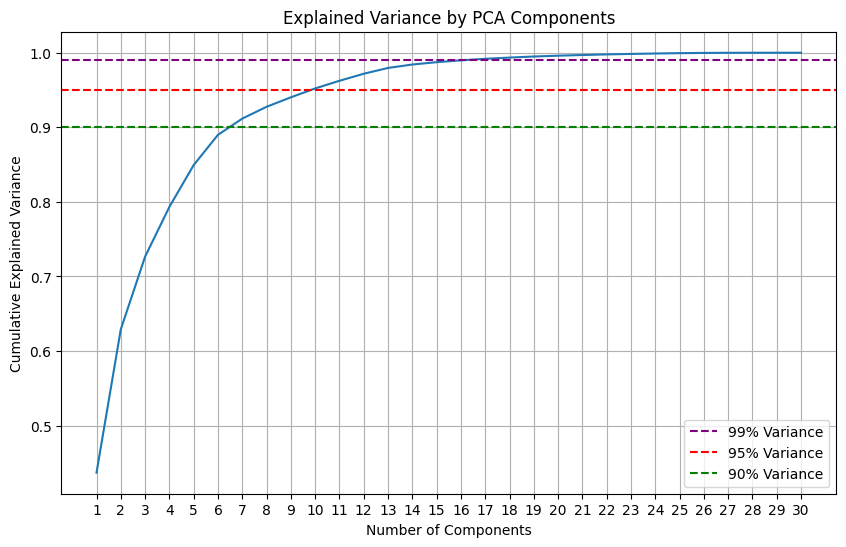

PCA explained variance analysis complete. Review the plot to choose N_PCA_COMPONENTS for the next cell.


In [23]:
# --- 2.5. Dimensionality Reduction (PCA) - Analysis ---
print("\nAnalyzing PCA explained variance...")
pca_analyzer = PCA(random_state=SEED)
pca_analyzer.fit(X_train_scaled)

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(pca_analyzer.explained_variance_ratio_) + 1), np.cumsum(pca_analyzer.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by PCA Components')
plt.xticks(range(1, len(pca_analyzer.explained_variance_ratio_) + 1)) # Ensure integer ticks
plt.grid(True)
plt.axhline(y=0.99, color='purple', linestyle='--', label='99% Variance')
plt.axhline(y=0.95, color='r', linestyle='--', label='95% Variance')
plt.axhline(y=0.90, color='g', linestyle='--', label='90% Variance')
plt.legend(loc='best')
plt.show()

print("PCA explained variance analysis complete. Review the plot to choose N_PCA_COMPONENTS for the next cell.")

In [24]:
# --- 2.5. Dimensionality Reduction (PCA) - Transformation ---
# IMPORTANT: Set N_PCA_COMPONENTS based on your analysis from the previous cell's plot !!!
N_PCA_COMPONENTS = 8 # Example: Choose based on plot (e.g., 6, 7, or 8)
print(f"\nApplying PCA with {N_PCA_COMPONENTS} components...")

pca = PCA(n_components=N_PCA_COMPONENTS, random_state=SEED)
X_train_pca = pca.fit_transform(X_train_scaled)
X_val_pca = pca.transform(X_val_scaled)
X_test_pca = pca.transform(X_test_scaled)

print(f"Shape after PCA: X_train_pca: {X_train_pca.shape}")
print(f"Total variance explained by {N_PCA_COMPONENTS} components: {np.sum(pca.explained_variance_ratio_):.4f}")

print("PCA transformation complete.")


Applying PCA with 8 components...
Shape after PCA: X_train_pca: (398, 8)
Total variance explained by 8 components: 0.9275
PCA transformation complete.


In [25]:
# ---------------------------------------------------------------------------
# 3. Classical Baseline Models & Explainability
# ---------------------------------------------------------------------------

# --- Helper function for evaluation ---
def evaluate_model(y_true, y_pred, y_pred_proba, model_name="Model"):
    accuracy = accuracy_score(y_true, y_pred)
    # Use pos_label=1 if your positive class is 1
    precision = precision_score(y_true, y_pred, pos_label=1, zero_division=0)
    recall = recall_score(y_true, y_pred, pos_label=1, zero_division=0)
    f1 = f1_score(y_true, y_pred, pos_label=1, zero_division=0)
    mcc = matthews_corrcoef(y_true, y_pred)

    auc_roc = roc_auc_score(y_true, y_pred_proba) # y_pred_proba should be for the positive class
    auc_pr = average_precision_score(y_true, y_pred_proba) # y_pred_proba should be for the positive class

    print(f"\n--- {model_name} Evaluation (Positive Class: 1=Malignant) ---")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-score: {f1:.4f}")
    print(f"MCC: {mcc:.4f}")
    print(f"AUC-ROC: {auc_roc:.4f}")
    print(f"AUC-PR (Average Precision): {auc_pr:.4f}")

    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1]) # Benign (0), Malignant (1)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f'Confusion Matrix - {model_name}')
    plt.show()
    return {"accuracy": accuracy, "precision": precision, "recall": recall, "f1": f1, "mcc": mcc, "auc_roc": auc_roc, "auc_pr": auc_pr}

print("Evaluation helper function defined.")

Evaluation helper function defined.



Training Logistic Regression...

--- Logistic Regression Evaluation (Positive Class: 1=Malignant) ---
Accuracy: 0.9884
Precision: 0.9697
Recall: 1.0000
F1-score: 0.9846
MCC: 0.9756
AUC-ROC: 0.9994
AUC-PR (Average Precision): 0.9991


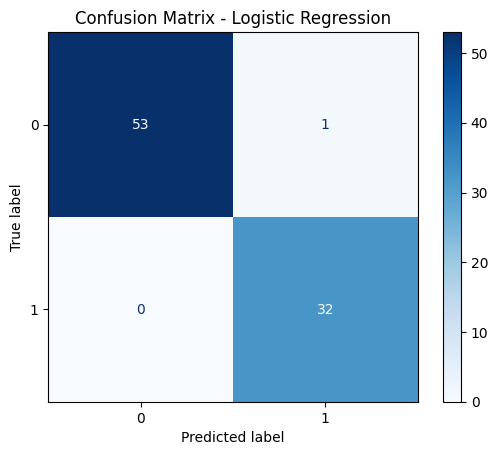

Logistic Regression training and evaluation complete.


In [26]:
# --- 3.1. Logistic Regression ---
print("\nTraining Logistic Regression...")
log_reg = LogisticRegression(solver='liblinear', class_weight='balanced', random_state=SEED)
log_reg.fit(X_train_pca, y_train)

y_pred_log_reg = log_reg.predict(X_test_pca)
y_pred_proba_log_reg = log_reg.predict_proba(X_test_pca)[:, 1] # Probabilities for the positive class (Malignant=1)

log_reg_metrics = evaluate_model(y_test, y_pred_log_reg, y_pred_proba_log_reg, "Logistic Regression")
print("Logistic Regression training and evaluation complete.")

In [27]:
# --- 3.2. PyTorch MLP ---
# --- 3.2.1. PyTorch Datasets and DataLoaders ---
BATCH_SIZE = 32

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train_pca, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
X_val_tensor = torch.tensor(X_val_pca, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32).unsqueeze(1)
X_test_tensor = torch.tensor(X_test_pca, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1) # Keep y_test separate for final eval

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset_for_loader = TensorDataset(X_test_tensor, y_test_tensor) # For loader during eval

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset_for_loader, batch_size=BATCH_SIZE, shuffle=False) # Use this for evaluation loop

print("PyTorch Datasets and DataLoaders created.")

PyTorch Datasets and DataLoaders created.


In [28]:
# --- 3.2.2. MLP Model Definition (Corrected for BCEWithLogitsLoss) ---
class SimpleMLP(nn.Module):
    def __init__(self, input_size, hidden_size1, output_size=1):
        super(SimpleMLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.relu1 = nn.ReLU()
        self.fc_out = nn.Linear(hidden_size1, output_size) # Output raw logits

    def forward(self, x):
        x = self.relu1(self.fc1(x))
        x = self.fc_out(x) # Return raw logits
        return x

# Model instantiation
INPUT_SIZE_MLP = N_PCA_COMPONENTS # From Cell 7
HIDDEN_SIZE_MLP1 = 16 # You can tune this
# HIDDEN_SIZE_MLP2 = 8  # If using a second hidden layer
OUTPUT_SIZE_MLP = 1

mlp_model = SimpleMLP(INPUT_SIZE_MLP, HIDDEN_SIZE_MLP1, OUTPUT_SIZE_MLP)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
mlp_model.to(device)

print(f"\nMLP Model Architecture (Corrected for BCEWithLogitsLoss):\n{mlp_model}")
print(f"Model is on device: {device}")
print("PyTorch MLP model defined.")


MLP Model Architecture (Corrected for BCEWithLogitsLoss):
SimpleMLP(
  (fc1): Linear(in_features=8, out_features=16, bias=True)
  (relu1): ReLU()
  (fc_out): Linear(in_features=16, out_features=1, bias=True)
)
Model is on device: cpu
PyTorch MLP model defined.


In [29]:
# --- 3.2.3. Loss Function with Class Weights & Optimizer ---
# Calculate pos_weight for BCEWithLogitsLoss to handle imbalance.
# pos_weight = count_negative / count_positive
count_positive_train = np.sum(y_train == 1)
count_negative_train = np.sum(y_train == 0)

if count_positive_train > 0:
    pos_weight_val = count_negative_train / count_positive_train
else:
    pos_weight_val = 1.0 # Default if no positive samples
    print("Warning: No positive samples in training set for pos_weight calculation.")

pos_weight_tensor = torch.tensor([pos_weight_val], dtype=torch.float32).to(device)
print(f"Calculated pos_weight for BCEWithLogitsLoss: {pos_weight_tensor.item():.4f}")

# Use BCEWithLogitsLoss
criterion_mlp = nn.BCEWithLogitsLoss(pos_weight=pos_weight_tensor)
optimizer_mlp = optim.Adam(mlp_model.parameters(), lr=0.001) # Tune learning rate

print("MLP Loss function (BCEWithLogitsLoss) and optimizer defined.")

Calculated pos_weight for BCEWithLogitsLoss: 1.6892
MLP Loss function (BCEWithLogitsLoss) and optimizer defined.


**WITHOUT EARLY STOPPING**

In [34]:
# --- 3.2.4. MLP Training Loop (Corrected for BCEWithLogitsLoss) ---
print("\nTraining PyTorch MLP...")
N_EPOCHS = 50 # Train for the full number of epochs

train_losses_mlp, val_losses_mlp = [], []
train_f1s_mlp, val_f1s_mlp = [], []


for epoch in range(N_EPOCHS):
    mlp_model.train()
    epoch_train_loss = 0
    all_train_preds_epoch, all_train_targets_epoch = [], []

    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer_mlp.zero_grad()

        logits = mlp_model(X_batch) # Model outputs raw logits
        loss = criterion_mlp(logits, y_batch) # BCEWithLogitsLoss takes logits

        loss.backward()
        optimizer_mlp.step()
        epoch_train_loss += loss.item()

        # For F1 score, convert logits to probabilities then to predictions
        probabilities = torch.sigmoid(logits)
        preds = (probabilities >= 0.5).float()
        all_train_preds_epoch.extend(preds.cpu().detach().numpy())
        all_train_targets_epoch.extend(y_batch.cpu().detach().numpy())

    avg_train_loss = epoch_train_loss / len(train_loader)
    train_losses_mlp.append(avg_train_loss)
    epoch_train_f1 = f1_score(all_train_targets_epoch, all_train_preds_epoch, pos_label=1, zero_division=0)
    train_f1s_mlp.append(epoch_train_f1)

    # Validation
    mlp_model.eval()
    epoch_val_loss = 0
    all_val_preds_epoch, all_val_targets_epoch = [], []
    with torch.no_grad():
        for X_batch_val, y_batch_val in val_loader:
            X_batch_val, y_batch_val = X_batch_val.to(device), y_batch_val.to(device)

            logits_val = mlp_model(X_batch_val) # Model outputs raw logits
            loss_val = criterion_mlp(logits_val, y_batch_val) # BCEWithLogitsLoss takes logits
            epoch_val_loss += loss_val.item()

            # For F1 score, convert logits to probabilities then to predictions
            probabilities_val = torch.sigmoid(logits_val)
            preds_val = (probabilities_val >= 0.5).float()
            all_val_preds_epoch.extend(preds_val.cpu().detach().numpy())
            all_val_targets_epoch.extend(y_batch_val.cpu().detach().numpy())

    avg_val_loss = epoch_val_loss / len(val_loader)
    val_losses_mlp.append(avg_val_loss)
    epoch_val_f1 = f1_score(all_val_targets_epoch, all_val_preds_epoch, pos_label=1, zero_division=0)
    val_f1s_mlp.append(epoch_val_f1)

    print(f"Epoch {epoch+1}/{N_EPOCHS} - Train Loss: {avg_train_loss:.4f}, Train F1: {epoch_train_f1:.4f} | Val Loss: {avg_val_loss:.4f}, Val F1: {epoch_val_f1:.4f}")

# After the loop finishes, save the model state from the last epoch
torch.save(mlp_model.state_dict(), "last_classical_mlp_model.pth")
print("\nTraining complete. Saved the model state from the last epoch to 'last_classical_mlp_model.pth'.")

print("PyTorch MLP training loop complete.")


Training PyTorch MLP...
Epoch 1/50 - Train Loss: 0.0877, Train F1: 0.9732 | Val Loss: 0.1107, Val F1: 0.9688
Epoch 2/50 - Train Loss: 0.0890, Train F1: 0.9732 | Val Loss: 0.1100, Val F1: 0.9688
Epoch 3/50 - Train Loss: 0.0910, Train F1: 0.9732 | Val Loss: 0.1100, Val F1: 0.9688
Epoch 4/50 - Train Loss: 0.0860, Train F1: 0.9697 | Val Loss: 0.1101, Val F1: 0.9688
Epoch 5/50 - Train Loss: 0.0857, Train F1: 0.9732 | Val Loss: 0.1098, Val F1: 0.9688
Epoch 6/50 - Train Loss: 0.0886, Train F1: 0.9732 | Val Loss: 0.1091, Val F1: 0.9688
Epoch 7/50 - Train Loss: 0.0860, Train F1: 0.9732 | Val Loss: 0.1095, Val F1: 0.9688
Epoch 8/50 - Train Loss: 0.0848, Train F1: 0.9732 | Val Loss: 0.1093, Val F1: 0.9688
Epoch 9/50 - Train Loss: 0.0886, Train F1: 0.9732 | Val Loss: 0.1088, Val F1: 0.9688
Epoch 10/50 - Train Loss: 0.0822, Train F1: 0.9732 | Val Loss: 0.1088, Val F1: 0.9688
Epoch 11/50 - Train Loss: 0.0837, Train F1: 0.9732 | Val Loss: 0.1088, Val F1: 0.9688
Epoch 12/50 - Train Loss: 0.0852, Trai

In [31]:
# --- 3.2.4. MLP Training Loop (Corrected for BCEWithLogitsLoss) ---
print("\nTraining PyTorch MLP...")
N_EPOCHS = 50 # Tune this; we can consider early stopping based on validation loss/F1
best_val_f1 = -1.0 # Initialize with a value that will be beaten
best_mlp_model_state = None
patience_counter = 0
PATIENCE_LIMIT = 10 # Number of epochs to wait for improvement before stopping

train_losses_mlp, val_losses_mlp = [], []
train_f1s_mlp, val_f1s_mlp = [], []


for epoch in range(N_EPOCHS):
    mlp_model.train()
    epoch_train_loss = 0
    all_train_preds_epoch, all_train_targets_epoch = [], []

    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer_mlp.zero_grad()

        logits = mlp_model(X_batch) # Model outputs raw logits
        loss = criterion_mlp(logits, y_batch) # BCEWithLogitsLoss takes logits

        loss.backward()
        optimizer_mlp.step()
        epoch_train_loss += loss.item()

        # For F1 score, convert logits to probabilities then to predictions
        probabilities = torch.sigmoid(logits)
        preds = (probabilities >= 0.5).float()
        all_train_preds_epoch.extend(preds.cpu().detach().numpy())
        all_train_targets_epoch.extend(y_batch.cpu().detach().numpy())

    avg_train_loss = epoch_train_loss / len(train_loader)
    train_losses_mlp.append(avg_train_loss)
    epoch_train_f1 = f1_score(all_train_targets_epoch, all_train_preds_epoch, pos_label=1, zero_division=0)
    train_f1s_mlp.append(epoch_train_f1)

    # Validation
    mlp_model.eval()
    epoch_val_loss = 0
    all_val_preds_epoch, all_val_targets_epoch = [], []
    with torch.no_grad():
        for X_batch_val, y_batch_val in val_loader:
            X_batch_val, y_batch_val = X_batch_val.to(device), y_batch_val.to(device)

            logits_val = mlp_model(X_batch_val) # Model outputs raw logits
            loss_val = criterion_mlp(logits_val, y_batch_val) # BCEWithLogitsLoss takes logits
            epoch_val_loss += loss_val.item()

            # For F1 score, convert logits to probabilities then to predictions
            probabilities_val = torch.sigmoid(logits_val)
            preds_val = (probabilities_val >= 0.5).float()
            all_val_preds_epoch.extend(preds_val.cpu().detach().numpy())
            all_val_targets_epoch.extend(y_batch_val.cpu().detach().numpy())

    avg_val_loss = epoch_val_loss / len(val_loader)
    val_losses_mlp.append(avg_val_loss)
    epoch_val_f1 = f1_score(all_val_targets_epoch, all_val_preds_epoch, pos_label=1, zero_division=0)
    val_f1s_mlp.append(epoch_val_f1)

    print(f"Epoch {epoch+1}/{N_EPOCHS} - Train Loss: {avg_train_loss:.4f}, Train F1: {epoch_train_f1:.4f} | Val Loss: {avg_val_loss:.4f}, Val F1: {epoch_val_f1:.4f}")

    if epoch_val_f1 > best_val_f1:
        best_val_f1 = epoch_val_f1
        best_mlp_model_state = mlp_model.state_dict().copy() # Important to copy
        patience_counter = 0 # Reset patience
        print(f"   New best validation F1: {best_val_f1:.4f}. Saving model state.")
    else:
        patience_counter += 1

    if patience_counter >= PATIENCE_LIMIT:
        print(f"Early stopping triggered at epoch {epoch+1} due to no improvement in validation F1 for {PATIENCE_LIMIT} epochs.")
        break

# Load best model state
if best_mlp_model_state:
    mlp_model.load_state_dict(best_mlp_model_state)
    torch.save(best_mlp_model_state, "best_classical_mlp_model.pth")
    print("\nBest MLP model state loaded and saved to 'best_classical_mlp_model.pth'.")
else:
    print("\nWarning: No best model state was saved. Training might not have improved validation F1.")
    torch.save(mlp_model.state_dict(), "last_classical_mlp_model.pth")
    print("Saved the last state of MLP model to 'last_classical_mlp_model.pth'.")

print("PyTorch MLP training loop complete.")


Training PyTorch MLP...
Epoch 1/50 - Train Loss: 0.0979, Train F1: 0.9697 | Val Loss: 0.1172, Val F1: 0.9688
   New best validation F1: 0.9688. Saving model state.
Epoch 2/50 - Train Loss: 0.0958, Train F1: 0.9697 | Val Loss: 0.1161, Val F1: 0.9688
Epoch 3/50 - Train Loss: 0.0950, Train F1: 0.9697 | Val Loss: 0.1153, Val F1: 0.9688
Epoch 4/50 - Train Loss: 0.0933, Train F1: 0.9697 | Val Loss: 0.1148, Val F1: 0.9688
Epoch 5/50 - Train Loss: 0.0930, Train F1: 0.9697 | Val Loss: 0.1142, Val F1: 0.9688
Epoch 6/50 - Train Loss: 0.0920, Train F1: 0.9697 | Val Loss: 0.1133, Val F1: 0.9688
Epoch 7/50 - Train Loss: 0.0940, Train F1: 0.9697 | Val Loss: 0.1129, Val F1: 0.9688
Epoch 8/50 - Train Loss: 0.0976, Train F1: 0.9697 | Val Loss: 0.1123, Val F1: 0.9688
Epoch 9/50 - Train Loss: 0.0951, Train F1: 0.9697 | Val Loss: 0.1113, Val F1: 0.9688
Epoch 10/50 - Train Loss: 0.0894, Train F1: 0.9697 | Val Loss: 0.1112, Val F1: 0.9688
Epoch 11/50 - Train Loss: 0.0891, Train F1: 0.9697 | Val Loss: 0.1107

**Adversal Robustness Testing**

In [6]:
!pip install pandas numpy scikit-learn torch adversarial-robustness-toolbox shap ucimlrepo


In [12]:
!pip install qiskit


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.5/6.5 MB 47.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 43.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.0/109.0 kB 10.0 MB/s eta 0:00:00


In [8]:
# ✅ Full Standalone Script: MLP + ART + PGD Attack on WDBC Dataset

# Step 1: Install Needed Packages
!pip install pandas numpy scikit-learn torch adversarial-robustness-toolbox

# Step 2: Imports
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
import torch
import torch.nn as nn
import torch.optim as optim
from art.estimators.classification import PyTorchClassifier
from art.attacks.evasion import ProjectedGradientDescent

# Step 3: Load and Preprocess WDBC Data
df = pd.read_csv("wdbc.data", header=None)
df = df.drop(columns=[0])  # Drop ID column
df.columns = ['diagnosis'] + [f'f{i}' for i in range(1, 31)]

# Encode diagnosis: M=1, B=0
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df['diagnosis'])
X = df.drop(columns=['diagnosis']).values.astype(np.float32)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Normalize
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Step 4: Define MLP Model
class SimpleMLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(30, 16)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(16, 1)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        return self.fc2(x)

# Initialize
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleMLP().to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Step 5: Train the MLP
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train.reshape(-1, 1), dtype=torch.float32).to(device)

for epoch in range(30):
    model.train()
    optimizer.zero_grad()
    logits = model(X_train_tensor)
    loss = criterion(logits, y_train_tensor)
    loss.backward()
    optimizer.step()
    if (epoch+1) % 5 == 0:
        probs = torch.sigmoid(logits).detach().cpu().numpy()
        preds = (probs >= 0.5).astype(int)
        acc = accuracy_score(y_train, preds)
        print(f"Epoch {epoch+1} | Loss: {loss.item():.4f} | Accuracy: {acc*100:.2f}%")

# Step 6: Wrap with ART
art_classifier = PyTorchClassifier(
    model=model,
    loss=criterion,
    optimizer=optimizer,
    input_shape=(30,),
    nb_classes=2,
    clip_values=(float(np.min(X_train)), float(np.max(X_train)))
)

# Step 7: PGD Attack (Stronger than FGSM)
pgd_attack = ProjectedGradientDescent(
    estimator=art_classifier,
    eps=0.2,
    eps_step=0.01,
    max_iter=40,
    num_random_init=3
)
X_test_pgd = pgd_attack.generate(x=X_test)

# Step 8: Evaluate Clean vs Adversarial
model.eval()
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
X_test_pgd_tensor = torch.tensor(X_test_pgd, dtype=torch.float32).to(device)

with torch.no_grad():
    clean_logits = model(X_test_tensor)
    clean_probs = torch.sigmoid(clean_logits).cpu().numpy().flatten()
    clean_preds = (clean_probs >= 0.5).astype(int)

    adv_logits = model(X_test_pgd_tensor)
    adv_probs = torch.sigmoid(adv_logits).cpu().numpy().flatten()
    adv_preds = (adv_probs >= 0.5).astype(int)

    print("\n--- Clean Test Data ---")
    print(f"Accuracy: {accuracy_score(y_test, clean_preds):.4f}")
    print(f"F1 Score: {f1_score(y_test, clean_preds):.4f}")

    print("\n--- PGD Adversarial Data ---")
    print(f"Accuracy: {accuracy_score(y_test, adv_preds):.4f}")
    print(f"F1 Score: {f1_score(y_test, adv_preds):.4f}")

    # Compare predictions
    changed = np.sum(clean_preds != adv_preds)
    total = len(y_test)
    print(f"\nChanged predictions: {changed}/{total} ({(changed/total)*100:.2f}%)")


Epoch 5 | Loss: 0.5751 | Accuracy: 84.18%
Epoch 10 | Loss: 0.5375 | Accuracy: 86.81%
Epoch 15 | Loss: 0.5028 | Accuracy: 89.67%
Epoch 20 | Loss: 0.4708 | Accuracy: 91.43%
Epoch 25 | Loss: 0.4411 | Accuracy: 91.65%
Epoch 30 | Loss: 0.4135 | Accuracy: 91.43%


PGD - Batches:   0%|          | 0/4 [00:00<?, ?it/s]


--- Clean Test Data ---
Accuracy: 0.9298
F1 Score: 0.9000

--- PGD Adversarial Data ---
Accuracy: 0.9035
F1 Score: 0.8533

Changed predictions: 5/114 (4.39%)


In [9]:
# ✅ Full Script: MLP + ART + PGD Adversarial Training + Evaluation

# Step 1: Install Needed Packages
!pip install pandas numpy scikit-learn torch adversarial-robustness-toolbox

# Step 2: Imports
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
import torch
import torch.nn as nn
import torch.optim as optim
from art.estimators.classification import PyTorchClassifier
from art.attacks.evasion import ProjectedGradientDescent
from art.utils import to_categorical

# Step 3: Load and Preprocess WDBC Data
df = pd.read_csv("wdbc.data", header=None)
df = df.drop(columns=[0])  # Drop ID column
df.columns = ['diagnosis'] + [f'f{i}' for i in range(1, 31)]

# Encode diagnosis: M=1, B=0
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df['diagnosis'])
X = df.drop(columns=['diagnosis']).values.astype(np.float32)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Normalize
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Step 4: Define MLP Model
class SimpleMLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(30, 16)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(16, 1)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        return self.fc2(x)

# Initialize
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleMLP().to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Step 5: Wrap with ART for Adversarial Training
art_classifier = PyTorchClassifier(
    model=model,
    loss=criterion,
    optimizer=optimizer,
    input_shape=(30,),
    nb_classes=2,
    clip_values=(float(np.min(X_train)), float(np.max(X_train)))
)

# Step 6: Define PGD Attack for Adversarial Training
pgd_attack = ProjectedGradientDescent(
    estimator=art_classifier,
    eps=0.2,
    eps_step=0.01,
    max_iter=10,
    num_random_init=1
)

# Step 7: Adversarial Training Loop
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.reshape(-1, 1), dtype=torch.float32)

EPOCHS = 30
for epoch in range(EPOCHS):
    model.train()
    # Generate adversarial examples for training batch
    X_adv_train = pgd_attack.generate(x=X_train)
    X_combined = np.concatenate([X_train, X_adv_train])
    y_combined = np.concatenate([y_train, y_train])

    # Convert to tensor and shuffle
    indices = np.arange(len(X_combined))
    np.random.shuffle(indices)
    X_combined = torch.tensor(X_combined[indices], dtype=torch.float32).to(device)
    y_combined = torch.tensor(y_combined[indices].reshape(-1, 1), dtype=torch.float32).to(device)

    optimizer.zero_grad()
    logits = model(X_combined)
    loss = criterion(logits, y_combined)
    loss.backward()
    optimizer.step()

    with torch.no_grad():
        probs = torch.sigmoid(logits).cpu().numpy()
        preds = (probs >= 0.5).astype(int)
        acc = accuracy_score(y_combined.cpu().numpy(), preds)
        print(f"Epoch {epoch+1} | Adversarial Training Loss: {loss.item():.4f} | Accuracy: {acc*100:.2f}%")

# Step 8: Final Evaluation
model.eval()
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)

with torch.no_grad():
    clean_logits = model(X_test_tensor)
    clean_probs = torch.sigmoid(clean_logits).cpu().numpy().flatten()
    clean_preds = (clean_probs >= 0.5).astype(int)
    print("\n--- Clean Test Data After Adversarial Training ---")
    print(f"Accuracy: {accuracy_score(y_test, clean_preds):.4f}")
    print(f"F1 Score: {f1_score(y_test, clean_preds):.4f}")

# Step 9: PGD Evaluation Post-Training
X_test_pgd = pgd_attack.generate(x=X_test)
X_test_pgd_tensor = torch.tensor(X_test_pgd, dtype=torch.float32).to(device)

with torch.no_grad():
    adv_logits = model(X_test_pgd_tensor)
    adv_probs = torch.sigmoid(adv_logits).cpu().numpy().flatten()
    adv_preds = (adv_probs >= 0.5).astype(int)
    print("\n--- PGD Adversarial Test Data After Adversarial Training ---")
    print(f"Accuracy: {accuracy_score(y_test, adv_preds):.4f}")
    print(f"F1 Score: {f1_score(y_test, adv_preds):.4f}")

    changed = np.sum(clean_preds != adv_preds)
    total = len(y_test)
    print(f"Changed predictions: {changed}/{total} ({(changed/total)*100:.2f}%)")


PGD - Batches:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 1 | Adversarial Training Loss: 0.5974 | Accuracy: 84.84%


PGD - Batches:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 2 | Adversarial Training Loss: 0.5911 | Accuracy: 85.05%


PGD - Batches:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 3 | Adversarial Training Loss: 0.5859 | Accuracy: 85.82%


PGD - Batches:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 4 | Adversarial Training Loss: 0.5796 | Accuracy: 86.26%


PGD - Batches:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 5 | Adversarial Training Loss: 0.5737 | Accuracy: 87.14%


PGD - Batches:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 6 | Adversarial Training Loss: 0.5681 | Accuracy: 87.14%


PGD - Batches:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 7 | Adversarial Training Loss: 0.5620 | Accuracy: 87.69%


PGD - Batches:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 8 | Adversarial Training Loss: 0.5564 | Accuracy: 88.24%


PGD - Batches:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 9 | Adversarial Training Loss: 0.5507 | Accuracy: 88.46%


PGD - Batches:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 10 | Adversarial Training Loss: 0.5444 | Accuracy: 89.12%


PGD - Batches:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 11 | Adversarial Training Loss: 0.5389 | Accuracy: 89.23%


PGD - Batches:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 12 | Adversarial Training Loss: 0.5332 | Accuracy: 90.00%


PGD - Batches:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 13 | Adversarial Training Loss: 0.5273 | Accuracy: 90.55%


PGD - Batches:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 14 | Adversarial Training Loss: 0.5217 | Accuracy: 90.77%


PGD - Batches:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 15 | Adversarial Training Loss: 0.5158 | Accuracy: 91.10%


PGD - Batches:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 16 | Adversarial Training Loss: 0.5101 | Accuracy: 91.54%


PGD - Batches:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 17 | Adversarial Training Loss: 0.5049 | Accuracy: 91.43%


PGD - Batches:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 18 | Adversarial Training Loss: 0.4992 | Accuracy: 91.87%


PGD - Batches:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 19 | Adversarial Training Loss: 0.4927 | Accuracy: 92.09%


PGD - Batches:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 20 | Adversarial Training Loss: 0.4874 | Accuracy: 92.20%


PGD - Batches:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 21 | Adversarial Training Loss: 0.4818 | Accuracy: 92.20%


PGD - Batches:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 22 | Adversarial Training Loss: 0.4762 | Accuracy: 92.75%


PGD - Batches:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 23 | Adversarial Training Loss: 0.4706 | Accuracy: 92.97%


PGD - Batches:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 24 | Adversarial Training Loss: 0.4649 | Accuracy: 92.86%


PGD - Batches:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 25 | Adversarial Training Loss: 0.4597 | Accuracy: 92.97%


PGD - Batches:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 26 | Adversarial Training Loss: 0.4540 | Accuracy: 93.30%


PGD - Batches:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 27 | Adversarial Training Loss: 0.4488 | Accuracy: 93.08%


PGD - Batches:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 28 | Adversarial Training Loss: 0.4432 | Accuracy: 93.63%


PGD - Batches:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 29 | Adversarial Training Loss: 0.4378 | Accuracy: 93.41%


PGD - Batches:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 30 | Adversarial Training Loss: 0.4322 | Accuracy: 93.52%

--- Clean Test Data After Adversarial Training ---
Accuracy: 0.9386
F1 Score: 0.9091


PGD - Batches:   0%|          | 0/4 [00:00<?, ?it/s]


--- PGD Adversarial Test Data After Adversarial Training ---
Accuracy: 0.8947
F1 Score: 0.8333
Changed predictions: 5/114 (4.39%)


In [49]:
!pip install qiskit

In [47]:
# Hybrid Quantum-Classical Model with Multiple Observables (ZZ + XX)

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, f1_score
import pandas as pd
from qiskit import QuantumCircuit
from qiskit.quantum_info import Statevector, Pauli

# Quantum Layer with Multiple Observables (ZZ and XX)
class VQALayerFunction(torch.autograd.Function):
    @staticmethod
    def forward(ctx, input_tensor, weights):
        input_vals = input_tensor.detach().cpu().numpy()
        weight_vals = weights.detach().cpu().numpy()
        outputs_zz = []
        outputs_xx = []

        for x in input_vals:
            qc = QuantumCircuit(2)
            for i in range(2):
                qc.ry(float(x[i]), i)
            qc.cx(0, 1)
            for i in range(2):
                qc.ry(float(weight_vals[i]), i)
            state = Statevector.from_instruction(qc)
            outputs_zz.append(np.real(state.expectation_value(Pauli("ZZ"))))
            outputs_xx.append(np.real(state.expectation_value(Pauli("XX"))))

        zz_tensor = torch.tensor(outputs_zz, dtype=torch.float32).reshape(-1, 1)
        xx_tensor = torch.tensor(outputs_xx, dtype=torch.float32).reshape(-1, 1)
        out = torch.cat([zz_tensor, xx_tensor], dim=1)

        ctx.save_for_backward(input_tensor, weights, out)
        return out

    @staticmethod
    def backward(ctx, grad_output):
        input_tensor, weights, _ = ctx.saved_tensors
        eps = 1e-3
        grad_weights = torch.zeros_like(weights)

        for i in range(len(weights)):
            plus = weights.clone()
            minus = weights.clone()
            plus[i] += eps
            minus[i] -= eps
            zz_plus, zz_minus = [], []
            xx_plus, xx_minus = [], []
            input_vals = input_tensor.detach().cpu().numpy()

            for x in input_vals:
                qc_p = QuantumCircuit(2)
                for j in range(2):
                    qc_p.ry(float(x[j]), j)
                qc_p.cx(0, 1)
                for j in range(2):
                    qc_p.ry(float(plus[j]), j)
                sv_p = Statevector.from_instruction(qc_p)
                zz_plus.append(np.real(sv_p.expectation_value(Pauli("ZZ"))))
                xx_plus.append(np.real(sv_p.expectation_value(Pauli("XX"))))

                qc_m = QuantumCircuit(2)
                for j in range(2):
                    qc_m.ry(float(x[j]), j)
                qc_m.cx(0, 1)
                for j in range(2):
                    qc_m.ry(float(minus[j]), j)
                sv_m = Statevector.from_instruction(qc_m)
                zz_minus.append(np.real(sv_m.expectation_value(Pauli("ZZ"))))
                xx_minus.append(np.real(sv_m.expectation_value(Pauli("XX"))))

            zz_diff = (torch.tensor(zz_plus) - torch.tensor(zz_minus)) / (2 * eps)
            xx_diff = (torch.tensor(xx_plus) - torch.tensor(xx_minus)) / (2 * eps)
            grad_sum = zz_diff.reshape(-1, 1) * grad_output[:, 0:1] + xx_diff.reshape(-1, 1) * grad_output[:, 1:2]
            grad_weights[i] = grad_sum.sum()

        return None, grad_weights.to(weights.device)

class VQALayer(nn.Module):
    def __init__(self):
        super().__init__()
        self.weights = nn.Parameter(torch.rand(2))

    def forward(self, x):
        return VQALayerFunction.apply(x[:, :2], self.weights)

class HybridModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.classical = nn.Sequential(
            nn.Linear(30, 4),
            nn.Tanh()
        )
        self.quantum = VQALayer()
        self.output = nn.Linear(2, 1)

    def forward(self, x):
        x = self.classical(x)
        x = self.quantum(x)
        return self.output(x)







In [48]:
# ----------------------------- #
#     1. Load and preprocess   #
# ----------------------------- #

# Load WDBC data
df = pd.read_csv("wdbc.data", header=None)
df = df.drop(columns=[0])  # drop ID
df[1] = LabelEncoder().fit_transform(df[1])  # M=1, B=0

X = df.iloc[:, 1:].values.astype(np.float32)
y = df.iloc[:, 0].values.astype(np.int64)

scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

X_train_tensor = torch.tensor(X_train)
y_train_tensor = torch.tensor(y_train).float().reshape(-1, 1)
X_test_tensor = torch.tensor(X_test)
y_test_tensor = torch.tensor(y_test).float().reshape(-1, 1)

# ----------------------------- #
#        2. Train Model        #
# ----------------------------- #

model = HybridModel()
optimizer = optim.Adam(model.parameters(), lr=0.01)
loss_fn = nn.BCEWithLogitsLoss()

for epoch in range(30):
    model.train()
    optimizer.zero_grad()
    preds = model(X_train_tensor)
    loss = loss_fn(preds, y_train_tensor)
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 5 == 0:
        with torch.no_grad():
            logits = model(X_test_tensor)
            pred_labels = (torch.sigmoid(logits) > 0.5).int().numpy()
            acc = accuracy_score(y_test, pred_labels)
            print(f"Epoch {epoch+1} | Loss: {loss.item():.4f} | Accuracy: {acc:.4f}")

# ----------------------------- #
#      3. Manual PGD Attack    #
# ----------------------------- #


X_adv = X_test_tensor.clone().detach()
X_adv.requires_grad = True

for step in range(20):
    model.zero_grad()
    outputs = model(X_adv)
    loss = loss_fn(outputs, y_test_tensor)
    loss.backward()

    if X_adv.grad is not None:
        perturb = 0.02 * X_adv.grad.sign()
        X_adv = X_adv.detach() + perturb
        X_adv = torch.clamp(X_adv, -3, 3)
        X_adv.requires_grad = True
    else:
        print("No gradient found. Skipping PGD.")
        break

# ----------------------------- #
#    4. Evaluate Clean vs PGD  #
# ----------------------------- #

with torch.no_grad():
    logits_clean = model(X_test_tensor)
    preds_clean = (torch.sigmoid(logits_clean) > 0.5).int().numpy()
    acc_clean = accuracy_score(y_test, preds_clean)
    f1_clean = f1_score(y_test, preds_clean)

    logits_adv = model(X_adv)
    preds_adv = (torch.sigmoid(logits_adv) > 0.5).int().numpy()
    acc_adv = accuracy_score(y_test, preds_adv)
    f1_adv = f1_score(y_test, preds_adv)

print("\n--- Hybrid Model Evaluation ---")
print(f"Clean Accuracy: {acc_clean:.4f}, F1: {f1_clean:.4f}")
print(f"Adversarial Accuracy (Quantum-PGD): {acc_adv:.4f}, F1: {f1_adv:.4f}")




Epoch 5 | Loss: 0.7219 | Accuracy: 0.3860
Epoch 10 | Loss: 0.6977 | Accuracy: 0.4912
Epoch 15 | Loss: 0.6771 | Accuracy: 0.6930
Epoch 20 | Loss: 0.6601 | Accuracy: 0.6579
Epoch 25 | Loss: 0.6462 | Accuracy: 0.6491
Epoch 30 | Loss: 0.6348 | Accuracy: 0.6404

--- Hybrid Model Evaluation ---
Clean Accuracy: 0.6404, F1: 0.0465
Adversarial Accuracy (Quantum-PGD): 0.6404, F1: 0.0465


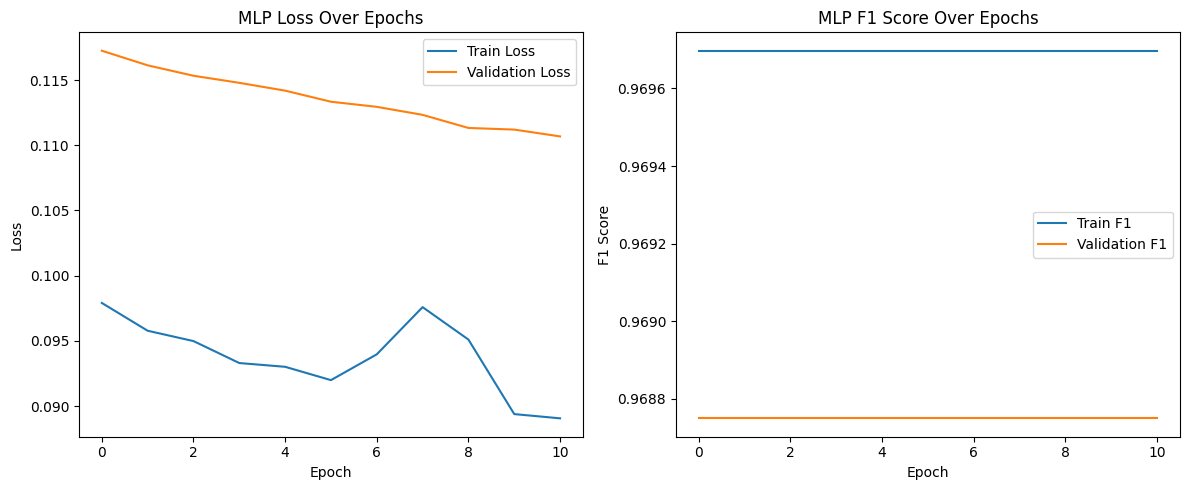


--- PyTorch MLP Evaluation (Positive Class: 1=Malignant) ---
Accuracy: 0.9884
Precision: 1.0000
Recall: 0.9688
F1-score: 0.9841
MCC: 0.9753
AUC-ROC: 1.0000
AUC-PR (Average Precision): 1.0000


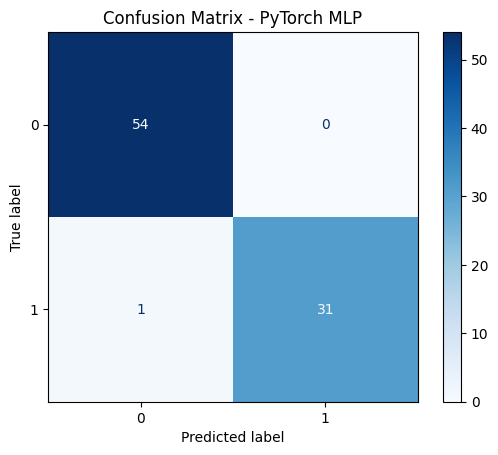

MLP evaluation on test set and training history plotting complete.


In [32]:
# --- Plot training history ---
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses_mlp, label='Train Loss')
plt.plot(val_losses_mlp, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('MLP Loss Over Epochs')

plt.subplot(1, 2, 2)
plt.plot(train_f1s_mlp, label='Train F1')
plt.plot(val_f1s_mlp, label='Validation F1')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.legend()
plt.title('MLP F1 Score Over Epochs')
plt.tight_layout()
plt.show()

# --- 3.2.5. MLP Evaluation on Test Set (Corrected for BCEWithLogitsLoss) ---
mlp_model.eval() # Ensure model is in evaluation mode
y_pred_mlp_list = []
y_pred_proba_mlp_list = []
with torch.no_grad():
    for X_batch_test, _ in test_loader: # y_true for test set is y_test
        X_batch_test = X_batch_test.to(device)

        logits_test = mlp_model(X_batch_test) # Model outputs logits

        probabilities_test = torch.sigmoid(logits_test) # Apply sigmoid for probabilities
        y_pred_proba_mlp_list.extend(probabilities_test.cpu().numpy().flatten())

        preds_test = (probabilities_test >= 0.5).float() # Make predictions from probabilities
        y_pred_mlp_list.extend(preds_test.cpu().numpy().flatten())

y_pred_mlp = np.array(y_pred_mlp_list)
y_pred_proba_mlp = np.array(y_pred_proba_mlp_list)

# Ensure y_test is used for evaluation (it's a numpy array defined in Cell 4)
mlp_metrics = evaluate_model(y_test, y_pred_mlp, y_pred_proba_mlp, "PyTorch MLP")
print("MLP evaluation on test set and training history plotting complete.")


Applying SHAP to PyTorch MLP...


  0%|          | 0/50 [00:00<?, ?it/s]

Raw SHAP values shape: (50, 8, 1)
Squeezing SHAP values from 3D to 2D.
Processed SHAP values shape for plotting: (50, 8)
SHAP values calculated. Plotting summary...


<ipython-input-33-d36023987afd>:41: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values_to_plot, shap_test_sample, feature_names=pca_feature_names, show=False)


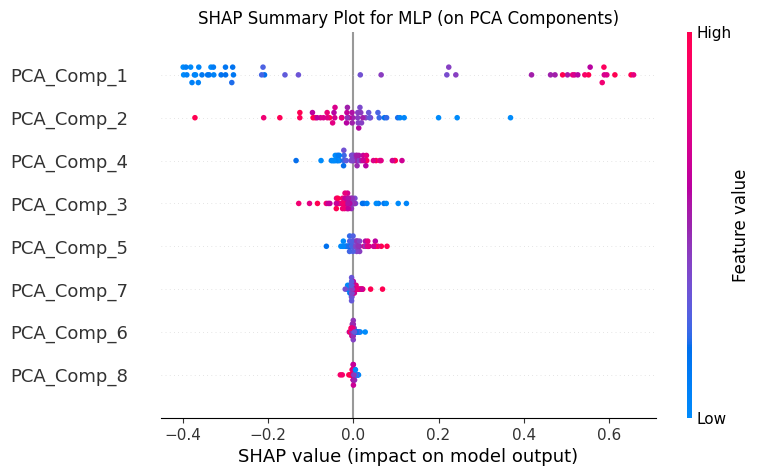

Most important PCA component for MLP (by SHAP): PCA_Comp_1


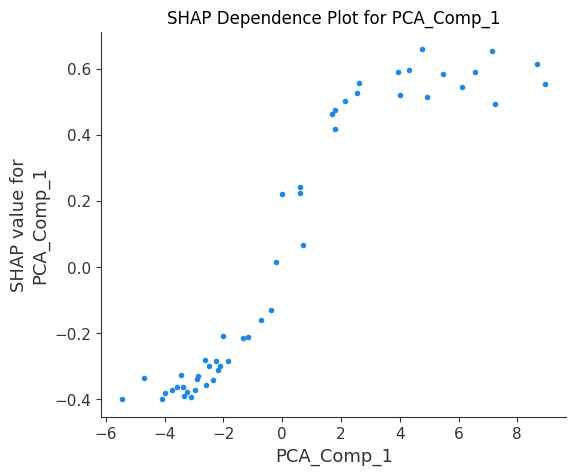

SHAP explainability complete. Phase 1 finished (Corrected).


In [33]:
# --- 3.3. Explainability (SHAP for MLP) ---
print("\nApplying SHAP to PyTorch MLP...")

mlp_model.to("cpu")

def mlp_predict_proba_for_shap(data_np):
    mlp_model.eval()
    data_tensor = torch.tensor(data_np, dtype=torch.float32).to("cpu")
    with torch.no_grad():
        logits = mlp_model(data_tensor)
        proba = torch.sigmoid(logits).cpu().numpy()
    return proba

background_data_shap = shap.sample(X_train_pca, min(100, X_train_pca.shape[0]))
explainer_mlp = shap.KernelExplainer(mlp_predict_proba_for_shap, background_data_shap)

shap_test_sample = X_test_pca[:min(50, X_test_pca.shape[0])]
shap_values_mlp_raw = explainer_mlp.shap_values(shap_test_sample) # Get the raw output

print(f"Raw SHAP values shape: {np.array(shap_values_mlp_raw).shape}") # Debug print

# Handle potential list output or extra dimension from KernelExplainer for single-output models
if isinstance(shap_values_mlp_raw, list):
    if len(shap_values_mlp_raw) > 0:
        shap_values_to_plot = shap_values_mlp_raw[0] # Assuming the first element is for the positive class
    else:
        print("SHAP values list is empty. Cannot plot.")
        shap_values_to_plot = np.array([])
elif shap_values_mlp_raw.ndim == 3 and shap_values_mlp_raw.shape[-1] == 1:
    print("Squeezing SHAP values from 3D to 2D.")
    shap_values_to_plot = np.squeeze(shap_values_mlp_raw, axis=-1)
else:
    shap_values_to_plot = shap_values_mlp_raw

print(f"Processed SHAP values shape for plotting: {shap_values_to_plot.shape}") # Debug print
print("SHAP values calculated. Plotting summary...")

pca_feature_names = [f'PCA_Comp_{i+1}' for i in range(N_PCA_COMPONENTS)]

if shap_values_to_plot.ndim == 2 and shap_values_to_plot.shape[0] > 0 and shap_values_to_plot.shape[1] == N_PCA_COMPONENTS:
    shap.summary_plot(shap_values_to_plot, shap_test_sample, feature_names=pca_feature_names, show=False)
    plt.title("SHAP Summary Plot for MLP (on PCA Components)")
    plt.show()

    mean_abs_shap = np.abs(shap_values_to_plot).mean(0)
    if len(mean_abs_shap) > 0:
        most_important_idx = np.argmax(mean_abs_shap)
        print(f"Most important PCA component for MLP (by SHAP): {pca_feature_names[most_important_idx]}")

        shap.dependence_plot(
            most_important_idx,
            shap_values_to_plot,
            shap_test_sample,
            feature_names=pca_feature_names,
            interaction_index=None,
            show=False
        )
        plt.title(f"SHAP Dependence Plot for {pca_feature_names[most_important_idx]}")
        plt.show()
    else:
        print("Could not determine the most important feature from SHAP values (empty mean_abs_shap).")
else:
    print(f"SHAP values array has an unexpected shape: {shap_values_to_plot.shape} or is empty after processing. Skipping SHAP plots.")
    print(f"Expected shape for plotting: (num_samples, {N_PCA_COMPONENTS})")

print("SHAP explainability complete. Phase 1 finished (Corrected).")